Цель: Подготовить данные, применить методы отбора признаков и интерпретировать
результаты с использованием градиентного бустинга и SHAP
* Загрузка и исследование данных:
    1. Загрузите набор данных о диабете.
    2. Исследуйте данные, чтобы понять структуру и основные характеристики.
* Структура данных
    * Датасет состоит из 768 записей (строк) и 9 признаков (столбцов):
        1. Pregnancies: Количество беременностей.
        2. Glucose: Уровень глюкозы в плазме (за 2 часа теста на толерантность к глюкозе).
        3. BloodPressure: Диастолическое артериальное давление (мм рт. ст.).
        4. SkinThickness: Толщина кожной складки трицепса (мм).
        5. Insulin: Уровень инсулина в сыворотке крови (μU/ml).
        6. BMI: Индекс массы тела (вес в кг/(рост в м)^2).
        7. DiabetesPedigreeFunction: Функция родства диабета (оценка вероятности диабета
        на основе наследственности).
        8. Age: Возраст (лет).
        9. Outcome: Целевая переменная (1 – наличие диабета, 0 – отсутствие диабета).
* Шаг 1: Методы отбора признаков
    * Выберите один из методов отбора признаков и примените его
* Шаг 2: Градиентный бустинг
    * Обучение модели с использованием градиентного бустинга:
        * Используйте библиотеку LightGBM (или Catboost/XGboost на выбор) для обучения модели.
        * Оцените значимость признаков с помощью feature importance.
    * Отбор лучших признаков:
        * Отберите признаки на основе их важности.
        * Повторно обучите модель с использованием только отобранных признаков.
* Шаг 3: Интерпретация результатов
    * Используйте SHAP для интерпретации вкладов каждого признака в предсказания модели.
    * Визуализируйте результаты с помощью графиков SHAP.

In [34]:
import pandas as pd

data = pd.read_csv('diabetes_.csv')

# Исследование данных
print(data.head())
print(data.describe())
print(data.info())
print(data.isnull().sum())

   Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
0            6      148             72             35        0  33.6   
1            1       85             66             29        0  26.6   
2            8      183             64              0        0  23.3   
3            1       89             66             23       94  28.1   
4            0      137             40             35      168  43.1   

   DiabetesPedigreeFunction  Age  Outcome  
0                     0.627   50        1  
1                     0.351   31        0  
2                     0.672   32        1  
3                     0.167   21        0  
4                     2.288   33        1  
       Pregnancies     Glucose  BloodPressure  SkinThickness     Insulin  \
count   768.000000  768.000000     768.000000     768.000000  768.000000   
mean      3.845052  120.894531      69.105469      20.536458   79.799479   
std       3.369578   31.972618      19.355807      15.952218  115.244002   

In [35]:
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestClassifier

# Определим модель
model = RandomForestClassifier(n_estimators=100, random_state=42)

# Отбор признаков
X = data.drop(columns='Outcome')
y = data['Outcome']

rfe = RFE(estimator=model, n_features_to_select=5)
rfe.fit(X, y)

# Итоги отбора признаков
selected_features = X.columns[rfe.support_]
print("Отобранные признаки:", selected_features.tolist())

Отобранные признаки: ['Glucose', 'BloodPressure', 'BMI', 'DiabetesPedigreeFunction', 'Age']


In [36]:
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

# Разделение данных на обучающую и тестовую выборки
X = data[selected_features]
y = data['Outcome']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Обучение модели
lgbm = lgb.LGBMClassifier()
lgbm.fit(X_train, y_train)

# Прогнозирование
y_pred = lgbm.predict(X_test)

# Оценка модели
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.4f}')
print(classification_report(y_test, y_pred))

[LightGBM] [Info] Number of positive: 213, number of negative: 401
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000047 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 521
[LightGBM] [Info] Number of data points in the train set: 614, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.346906 -> initscore=-0.632669
[LightGBM] [Info] Start training from score -0.632669
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

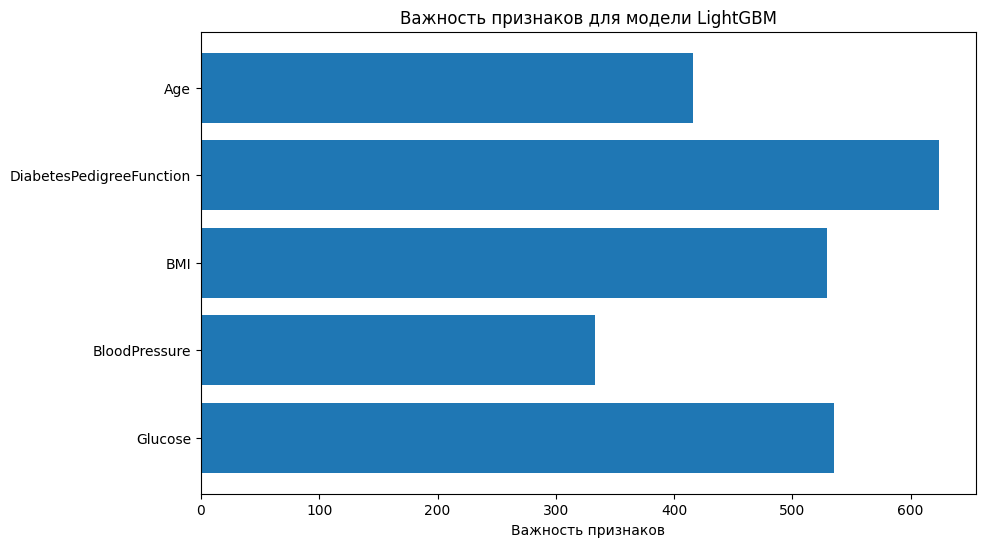

In [37]:
import matplotlib.pyplot as plt

# Важность признаков
feature_importances = lgbm.feature_importances_
plt.figure(figsize=(10, 6))
plt.barh(selected_features, feature_importances)
plt.xlabel('Важность признаков')
plt.title('Важность признаков для модели LightGBM')
plt.show()

c:\Dev\ml\ML_Homework\venv\Lib\site-packages\shap\explainers\_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')


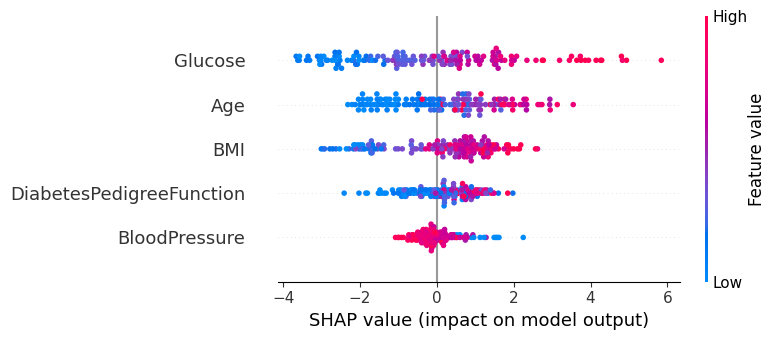

In [50]:
import shap

# Создание SHAP объяснителя
explainer = shap.TreeExplainer(lgbm)
shap_values = explainer.shap_values(X_test)

# Визуализация SHAP значений
shap.summary_plot(shap_values, X_test)